# Before you start

1. Please copy the code from the previous assignment (week 2) into a separate file `blocks.py`. Make sure it resides in the same folder as this notebook. It should contain the implementation of the building blocks. 
2. Downlod the files from [here](http://yann.lecun.com/exdb/mnist/) and place them next to this notebook. You should have 4 files: `t10k-images-idx3-ubyte
3. All functions should be implemented using [**NumPy**](https://docs.scipy.org/doc/).

The goal of this assignment is to supply you with the **building blocks** of **neural networks** (NNs). In this notebook, we will cover the main aspects of NNs, such as **Backpropagation** and **Optimization Methods**. 
You will understand how **Convolutional Neural Networks** and the basics of **image filtering** work. We will implement matrix convolution as well as the convolutional layer from scratch.


### Note
Some of the concepts below have not (yet) been discussed during the lecture. These will be discussed further during the next lectures. 

# Table of contents

* [1. Fully-Connected Neural Networks](#1.-Fully-Connected-Neural-Networks)
    * [1.1 Backpropagation](#1.1-Backpropagation)
    * [1.2 Dense layer](#1.2-Dense-layer)
    * [1.3 ReLU nonlinearity](#1.3-ReLU-nonlinearity)
    * [1.4 Sigmoid nonlinearity](#1.4-Sigmoid-nonlinearity)
    * [1.5 Sequential model](#1.5-Sequential-model)
    * [1.6 NLL loss function](#1.6-NLL-loss-function)
    * [1.7 $L_2$ regularization](#1.7-$L_2$-regularization)
    * [1.8 SGD optimizer](#1.8-SGD-optimizer)
* [2. Experiments](#2.-Experiments)
* [3. Convolutions](#3.-Convolutions)
    * [3.1 Matrix convolution](#3.1-Matrix-convolution)
    * [3.2 Basic kernels](#3.2-Matrix-convolution)
    * [3.3 Convolutional layer](#3.3-Convolutional-layer)
    * [3.4 Pooling layer](#3.4-Pooling-layer)
    * [3.5 Flatten](#3.5-Flatten)
* [4. Image Experiments](#4.-Image-Experiments)

In [1]:
from __future__ import print_function, absolute_import, division 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import blocks

import automark as am

# fill in you student number as your username
username = '13906208'

# to check your progress, you can run this function
am.get_progress(username)

---------------------------------------------
| Chieling Yueh                             |
| chieling.yueh@student.uva.nl              |
---------------------------------------------
| box_blur                 | completed      |
| conv_matrix              | completed      |
| dense_forward            | completed      |
| dense_grad_W             | completed      |
| dense_grad_b             | completed      |
| dense_grad_input         | completed      |
| flatten_forward          | completed      |
| flatten_grad_input       | completed      |
| l2_regularizer           | completed      |
| linear_forward           | completed      |
| linear_grad_W            | completed      |
| linear_grad_b            | completed      |
| maxpool_forward          | completed      |
| nll_forward              | completed      |
| nll_grad_input           | completed      |
| relu_forward             | completed      |
| relu_grad_input          | completed      |
| sigmoid_forward          | compl

# 1. Fully-Connected Neural Networks

## 1.1 Backpropagation

Neural networks consist of several layers. Each layer is a function of several parameters that we call weights: $h = f(x, w)$ where $h$ is the layer, $x$ is a vector of inputs and w is a vector of weights. 
In the neural network, the output of one layer is the input for the next layer. This means we can chain the different functions. The whole neural network $F$ then becomes a composition of different functions. 
$$
F = f_k \circ f_{k-1} \circ \dots \ f_1\\
h_1 = f_1(x, w_1)\\
h_2 = f_2(h_1, w_2)\\
\dots \\
\dot{y} = f_k(h_{k-1}, w_k)
$$
In the above functions, $w_1$ and $w_2$ are different **weight vectors** that apply to the different layers $h_1$ and $h_2$. The weights of a neural network basically determine the effect certain outputs have on the next layer. (Please note: When searching for these terms on the internet, be aware that **weights** are sometimes called **parameters**, and $w$ is sometimes denoted as $\theta$.) 


At the end of every neural network, there is a loss function. A loss function calculates for the performance of the Neural Network. The calculation of this score depends on the task at hand. For classification tasks the loss function would calculate the difference between prediction and the correct value. In this case the function is a summation of this difference for each data point. Calculating this difference can, again, be done in different ways. One example that we have discussed in class is the squared-loss for linear regression. (Here, the difference between predicted and correct classification is squared so positive and negative differences don't cancel eachother.) 
$$\mathcal{L} = \tfrac{1}{2}\sum_{n = 1}^N (y_n - \dot{y}_n)^2$$
Here, $n$ denotes the different datapoints, $y_n$ and $\dot{y}$ represent the correct and the predicted value for that data point respectively. 



The smaller the outcome of this loss function, the better the Neural Network predicts the data. Therefore, we concentrate on **minimizing the loss function** as a means for **training** the neural network. 


Training is done with [Gradient descent](https://en.wikipedia.org/wiki/Gradient_descent). Another word for **gradient** is **derivative**. We use derivatives to update the weights of the neural network to make better predictions. 
The weights of the $k$-th layer are updated according to the following scheme:
$$
w_k \leftarrow w_k - \gamma \frac{\partial \mathcal{L}}{\partial w_k} 
$$
* $\partial f(x)/\partial x$ means the partial derivative of $f(x)$ with respect to $x$. 
* Hyperparameter $\gamma$ is called the *learning rate* (You'll learn more about hyperparameters later. For now, the only thing you'll have to know is that the value of a hyperparameter is set by you.) 
* Note that $k$ denotes a layer and $n$ denotes a data point.


The computation of $\partial \mathcal{L}/\partial w_k$ is done using the [chain rule](https://en.wikipedia.org/wiki/Chain_rule):
$$
\frac{\partial \mathcal{L}}{\partial w_k} = 
\frac{\partial \mathcal{L}}{\partial h_k}
\frac{\partial h_k}{\partial w_k} = 
\frac{\partial \mathcal{L}}{\partial h_{k+1}}
\frac{\partial h_{k+1}}{\partial h_k}
\frac{\partial h_k}{\partial w_k} = \dots
$$


Therefore, for each layer, we can calculate the following expressions: 
* $h_k = f_k(h_{k-1}, w_k)$ - the forward pass
* $\partial h_{k}/\partial h_{k-1}$ - the partial derivative of the output with respect to the input
* $\partial h_{k}/\partial w_k$ - the partial derivative of the output with respect to the parameters


This whole process of updating weights by calculating the gradient is called [Backpropagation](https://www.iro.umontreal.ca/~vincentp/ift3395/lectures/backprop_old.pdf). Click [here](https://www.youtube.com/watch?v=Ilg3gGewQ5U) for a pretty good video explaining backpropagation. 

## 1.2 Dense layer
A dense Layer is the basic layer of a neural network. (Other terms for dense layer are fully-connected layer and multiplicative layer.) A dense layer transforms an input matrix of size `(n_objects, d_in)` to a matrix of size `(n_objects, d_out)` (where d stands for dimensions) by performing the following operation:
$$
H = XW + b
$$
Here $H$ represents the function of the dense layer, $X$ is the input matrix, $W$ is the weight matrix for this layer and $b$ is the bias. The bias $b$ is a vector. 

A more detailed version of this function is: 
$$
H_{nk} = \sum\limits_{i=1}^{d_{in}} X_{ni}W_{ik} + b_k
$$
where $n$ denotes again a single data object and $k$ the $k^{th}$ layer.

**Example**: 

You have a neural network of just 1 layer. The inputs are points in a 3D space and you want to classify this point as either $-1$ or $1$. 
You have $75$ objects in your training set. 

Therefore, $X$ has shape $75 \times 3$. $H$ has shape $75 \times 1$. Weight $W$ of the layer has shape $3 \times 1$.

**NOTE: "Dense Layer" is linear. So its mapping is exactly the same as of "Linear" function from the previous week but `n_out` is not restricted to 1. We use name "Dense" in order to distinquish between these two functions**

In [2]:
def dense_forward(x_input, W, b):
    """Perform the mapping of the input
    # Arguments
        x_input: input of a dense layer - np.array of size `(n_objects, n_in)`
        W: np.array of size `(n_in, n_out)`
        b: np.array of size `(n_out,)`
    # Output
        the output of a dense layer 
        np.array of size `(n_objects, n_out)`
    """
    #################
    ### YOUR CODE ###
    #################
    output= np.dot(x_input, W) + b
    return output

In [17]:
am.test_student_function(username, dense_forward, ['x_input', 'W', 'b'])

Running local tests...
dense_forward successfully passed local tests
Running remote test...
Test was successful. Congratulations!


Now, you'll implement a backward pass. As decribed above, this is calculated with the gradient. To calculate the gradient, we'll use the chain rule: 
$$
\frac{\partial \mathcal{L}}{\partial X} = 
\frac{\partial \mathcal{L}}{\partial H}
\frac{\partial H}{\partial X}
$$

In [3]:
def dense_grad_input(x_input, grad_output, W, b):
    """Calculate the partial derivative of 
        the loss with respect to the input of the layer
    # Arguments
        x_input: input of a dense layer - np.array of size `(n_objects, n_in)`
        grad_output: partial derivative of the loss functions with 
            respect to the ouput of the dense layer 
            np.array of size `(n_objects, n_out)`
        W: np.array of size `(n_in, n_out)`
        b: np.array of size `(n_out,)`
    # Output
        the partial derivative of the loss with 
        respect to the input of the layer
        np.array of size `(n_objects, n_in)`
    """
    #################
    ### YOUR CODE ###
    #################
    grad_input = np.dot(grad_output, W.T)
    return grad_input

In [23]:
am.test_student_function(username, dense_grad_input, ['x_input', 'grad_output', 'W', 'b'])

Running local tests...
dense_grad_input successfully passed local tests
Running remote test...
Test was successful. Congratulations!


Now, instead of computing the gradient with respect to the input, we'll calculate the gradient with respect to the weights and to the bias: 
$$
\frac{\partial \mathcal{L}}{\partial W} = 
\frac{\partial \mathcal{L}}{\partial H}
\frac{\partial H}{\partial W} \\
\frac{\partial \mathcal{L}}{\partial b} = 
\frac{\partial \mathcal{L}}{\partial H}
\frac{\partial H}{\partial b} \\
$$

In [4]:
def dense_grad_W(x_input, grad_output, W, b):
    """Calculate the partial derivative of 
        the loss with respect to W parameter of the layer
    # Arguments
        x_input: input of a dense layer - np.array of size `(n_objects, n_in)`
        grad_output: partial derivative of the loss functions with 
            respect to the ouput of the dense layer 
            np.array of size `(n_objects, n_out)`
        W: np.array of size `(n_in, n_out)`
        b: np.array of size `(n_out,)`
    # Output
        the partial derivative of the loss 
        with respect to W parameter of the layer
        np.array of size `(n_in, n_out)`
    """
    #################
    ### YOUR CODE ###
    #################
    grad_W = x_input.T.dot(grad_output)
    return grad_W

In [25]:
am.test_student_function(username, dense_grad_W, ['x_input', 'grad_output', 'W', 'b'])

Running local tests...
dense_grad_W successfully passed local tests
Running remote test...
Test was successful. Congratulations!


In [5]:
def dense_grad_b(x_input, grad_output, W, b):
    """Calculate the partial derivative of 
        the loss with respect to b parameter of the layer
    # Arguments
        x_input: input of a dense layer - np.array of size `(n_objects, n_in)`
        grad_output: partial derivative of the loss functions with 
            respect to the ouput of the dense layer 
            np.array of size `(n_objects, n_out)`
        W: np.array of size `(n_in, n_out)`
        b: np.array of size `(n_out,)`
    # Output
        the partial derivative of the loss 
        with respect to b parameter of the layer
        np.array of size `(n_out,)`
    """
    #################
    ### YOUR CODE ###
    #################
    grad_b = grad_output.T.dot(np.ones(x_input.shape[0],))
    return grad_b

In [31]:
am.test_student_function(username, dense_grad_b, ['x_input', 'grad_output', 'W', 'b'])

Running local tests...
dense_grad_b successfully passed local tests
Running remote test...
Test was successful. Congratulations!


In [6]:
am.get_progress(username)

---------------------------------------------
| Chieling Yueh                             |
| chieling.yueh@student.uva.nl              |
---------------------------------------------
| box_blur                 | completed      |
| conv_matrix              | completed      |
| dense_forward            | completed      |
| dense_grad_W             | completed      |
| dense_grad_b             | completed      |
| dense_grad_input         | completed      |
| flatten_forward          | not attempted  |
| flatten_grad_input       | not attempted  |
| l2_regularizer           | completed      |
| linear_forward           | completed      |
| linear_grad_W            | completed      |
| linear_grad_b            | completed      |
| maxpool_forward          | not attempted  |
| nll_forward              | completed      |
| nll_grad_input           | completed      |
| relu_forward             | completed      |
| relu_grad_input          | completed      |
| sigmoid_forward          | compl

### Dense Layer Class

Here, we define a basic class for the dense layer. You will use this in the Experiments sections below. You don't need to know how this works; we implement it for you, but it is based on the functions you've written above. 

In [7]:
class Layer(object):
    
    def __init__(self):
        self.training_phase = True
        self.output = 0.0
        
    def forward(self, x_input):
        self.output = x_input
        return self.output
    
    def backward(self, x_input, grad_output):
        return grad_output
    
    def get_params(self):
        return []
    
    def get_params_gradients(self):
        return []

In [8]:
class Dense(Layer):
    
    def __init__(self, n_input, n_output):
        super(Dense, self).__init__()
        #Randomly initializing the weights from normal distribution
        self.W = np.random.normal(scale=0.01, size=(n_input, n_output))
        self.grad_W = np.zeros_like(self.W)
        #initializing the bias with zero
        self.b = np.zeros(n_output)
        self.grad_b = np.zeros_like(self.b)
      
    def forward(self, x_input):
        self.output = dense_forward(x_input, self.W, self.b)
        return self.output
    
    def backward(self, x_input, grad_output):
        # get gradients of weights
        self.grad_W = dense_grad_W(x_input, grad_output, self.W, self.b)
        self.grad_b = dense_grad_b(x_input, grad_output, self.W, self.b)
        # propagate the gradient backwards
        return dense_grad_input(x_input, grad_output, self.W, self.b)
    
    def get_params(self):
        return [self.W, self.b]

    def get_params_gradients(self):
        return [self.grad_W, self.grad_b]

In [9]:
dense_layer = Dense(2, 1)
x_input = np.random.random((3, 2))
y_output = dense_layer.forward(x_input)
print(x_input)
print(y_output)

[[0.35455716 0.67728614]
 [0.57898738 0.22500768]
 [0.70610657 0.9831956 ]]
[[-0.00321859]
 [ 0.00025372]
 [-0.00412325]]


## 1.3 ReLU nonlinearity

The dense layer, from previous section, is linear. Combinging several linear (dense) layers is always equivalent to a single dense layer. Here is the mathematically proof for this: 
$$
H_1 = XW_1 + b_1\\
H_2 = H_1W_2 + b_2\\
H_2 = (XW_1 + b_1)W_2 + b_2 = X(W_1W_2) + (b_1W_2 + b_2) = XW^* + b^*
$$


For this reason, we also need non-linear layers. Non-linear layers ($f$ in the following) are mostly element-wise and hold the following:
$$
H_1 = XW_1 + b_1\\
H_2 = f(H_1)W_2 + b_2\\
H_2 = f(XW_1 + b_1)W_2 + b_2 \neq XW^* + b^*
$$

A popular example of a simple non-linear layer is **ReLU** (Rectified Linear Unit). ReLU doesn't have weights that can be optimized like a dense layer.
$$
\text{ReLU}(x) = \max(0, x)
$$

<img src="./src/relu.png" width="500">

**Example**

$$
\text{ReLU} \Big(
\begin{bmatrix}
1 & -0.5 \\
0.3 & 0.1 
\end{bmatrix}
\Big) = 
\begin{bmatrix}
1 & 0 \\
0.3 & 0.1 
\end{bmatrix}
$$

Next, you will implement the forward pass and backward pass (gradient) for ReLU. 

In [10]:
def relu_forward(x_input):
    """relu nonlinearity
    # Arguments
        x_input: np.array of size `(n_objects, n_in)`
    # Output
        the output of relu layer
        np.array of size `(n_objects, n_in)`
    """
    #################
    ### YOUR CODE ###
    #################
    output = np.maximum(np.zeros(x_input.shape), x_input)
    return output

In [11]:
#test forward pass for ReLU, see example above
x_input = np.array([[1, -0.5],
                    [0.3, 0.1]])

print(relu_forward(x_input))

[[1.  0. ]
 [0.3 0.1]]


In [52]:
am.test_student_function(username, relu_forward, ['x_input'])

Running local tests...
relu_forward successfully passed local tests
Running remote test...
Test was successful. Congratulations!


In [12]:
def relu_grad_input(x_input, grad_output):
    """relu nonlinearity gradient. 
        Calculate the partial derivative of the loss 
        with respect to the input of the layer
    # Arguments
        x_input: np.array of size `(n_objects, n_in)`
            grad_output: np.array of size `(n_objects, n_in)`
    # Output
        the partial derivative of the loss 
        with respect to the input of the layer
        np.array of size `(n_objects, n_in)`
    """
    #################
    ### YOUR CODE ###
    #################
    grad_input = grad_output * (x_input > 0)
    return grad_input

In [64]:
am.test_student_function(username, relu_grad_input, ['x_input', 'grad_output'])

Running local tests...
relu_grad_input successfully passed local tests
Running remote test...
Test was successful. Congratulations!


In [13]:
class ReLU(Layer):
        
    def forward(self, x_input):
        self.output = relu_forward(x_input)
        return self.output
    
    def backward(self, x_input, grad_output):
        return relu_grad_input(x_input, grad_output)

## 1.4 Sigmoid nonlinearity

In [14]:
class Sigmoid(Layer):
        
    def forward(self, x_input):
        self.output = blocks.sigmoid_forward(x_input)
        return self.output
    
    def backward(self, x_input, grad_output):
        return blocks.sigmoid_grad_input(x_input, grad_output)

## 1.5 Sequential model
In order to make the work with layers more comfortable, we create `SequentialNN` - a class, which stores all its layers and performs the basic manipulations. Again, this is for the experiments below and you don't need to know how this works. 

In [15]:
class SequentialNN(object):

    def __init__(self, *layers):
        self.layers = layers
        self.training_phase = True
        
    def set_training_phase(self, is_training=True):
        self.training_phase = is_training
        for layer in self.layers:
            layer.training_phase = is_training
        
    def forward(self, x_input):
        self.output = x_input
        for layer in self.layers:
            self.output = layer.forward(self.output)
        return self.output
    
    def backward(self, x_input, grad_output):
        inputs = [x_input] + [l.output for l in self.layers[:-1]]
        for input_, layer_ in zip(inputs[::-1], self.layers[::-1]):
            grad_output = layer_.backward(input_, grad_output)
            
    def get_params(self):
        params = []
        for layer in self.layers:
            params.extend(layer.get_params())
        return params
    
    def get_params_gradients(self):
        grads = []
        for layer in self.layers:
            grads.extend(layer.get_params_gradients())
        return grads

Here is the simple neural network. It takes an input of shape `(Any, 10)` and passes it through `Dense(10, 4)`, `ReLU` and `Dense(4, 1)`. The output is a batch of size `(Any, 1)`. 
```
  INPUT
    |
Dense(10, 4)
    |
   ReLU
    |
Dense(4, 1)
    |
  OUTPUT
```

In [16]:
nn = SequentialNN(
    Dense(10, 4), 
    ReLU(),
    Dense(4, 1),
    Sigmoid()
)

In [17]:
nn.forward(np.ones([2, 10]))

array([[0.4999984],
       [0.4999984]])

## 1.6 NLL loss function
Here we will define the loss functions. Each loss should be able to compute its value and compute its gradient with respect to the input. We have implemented these functions (e.g. forward, backward) for you.  

In [18]:
class NLL(object):
    
    def forward(self, target_pred, target_true):
        self.output = blocks.nll_forward(target_pred, target_true)
        return self.output
    
    def backward(self, target_pred, target_true):
        return blocks.nll_grad_input(target_pred, target_true)

## 1.7 $L_2$ regularization

Loss functions update the weights of your model to improve your predictions. We do this by minimizing the loss function. However, up until now this loss function did not take into account the complexity of your model. Here we mean with complexity the number of parameters that your model stores. We do want to take complexity into account because complex models can perform poorly on test data, while performing excellent on train data. 

To penalize the complextity of the model, we introduce a regularizer. You'll learn more about regularizers in the lectures, but the general idea is that we take the values of the weights into account with the loss function. High values for weights are indicators of complexity. 

There are several ways of adding regularization to a model. We will implement [$L_2$ regularization](http://www.deeplearningbook.org/contents/regularization.html) also known as weight decay:

The key idea of $L_2$ regularization is to add an extra term to the loss functions:
$$
\mathcal{L}^* = \mathcal{L} + \frac{\lambda}{2} \|w\|^2_2
$$

The part we added to the loss function is called the regularization function. 
* $\lambda$ is named weight decay. It is a hyperparameter that determines the influence of the regularization to the outcome of the loss function. 
* $\|w\|^2_2$ is the squared [euclidian norm](https://en.wikipedia.org/wiki/Euclidean_distance) where $\|w\|^2_2 = \|w_1\|^2_2 + \|w_2\|^2_2 ... \|w_k\|^2_2$. 
This function in more detail becomes:

$$
\mathcal{L}^* = \mathcal{L} + \frac{\lambda}{2} \sum\limits_{m=1}^k \|w_m\|^2_2
$$

Because we use a different loss function, the updating of the weights is also slightly changed: 

$$
w_m \leftarrow w_m - \gamma \frac{\partial \mathcal{L}^*}{\partial w_m}\\
\frac{\partial \mathcal{L}^*}{\partial w_m} = \frac{\partial \mathcal{L}}{\partial w_m} + \lambda w_m\\
w_m \leftarrow w_m - \gamma \Big(\frac{\partial \mathcal{L}}{\partial w_m} + \lambda w_m\Big)
$$

Here, you'll implement the computation of $L_2$: 
$$
L_2(\lambda, [w_1, w_2, \dots, w_k]) = \frac{\lambda}{2} \sum\limits_{m=1}^k \|w_m\|^2_2
$$ 

In [105]:
def l2_regularizer(weight_decay, weights):
    """Compute the L2 regularization term
    # Arguments
        weight_decay: float
        weights: list of arrays of different shapes
    # Output
        sum of the L2 norms of the input weights
        scalar
    """
    #################
    ### YOUR CODE ###
    #################
    output = weight_decay/2 * np.sum(np.linalg.norm(weights)**2)
    return round(output, 2)

You can test your forward pass below. Your output should be: `108.25`

In [106]:
#test the L2 regularizer
weight_decay = 2
weights = np.array([5,3,7,5,0.5])
print(l2_regularizer(weight_decay, weights))

108.25


In [49]:
am.test_student_function(username, l2_regularizer, ['weight_decay', 'weights'])

Running local tests...
l2_regularizer successfully passed local tests
Running remote test...
Test was successful. Congratulations!


## 1.8 SGD optimizer

In [50]:
class SGD(object):
    '''
    Stochastic gradient descent optimizer
    https://en.wikipedia.org/wiki/Stochastic_gradient_descent
    '''
    def __init__(self, model, lr=0.01, weight_decay=0.0):
        self.model = model
        self.lr = lr
        self.weight_decay = weight_decay
        
    def update_params(self):
        weights = self.model.get_params()
        grads = self.model.get_params_gradients()
        for w, dw in zip(weights, grads):
            update = self.lr * (dw + self.weight_decay * w)
            # it writes the result to the previous variable instead of copying
            np.subtract(w, update, out=w) 

# 2. Experiments

In [51]:
# some function from week 2
def generate_2_circles(N=100):
    phi = np.linspace(0.0, np.pi * 2, 100)
    X1 = 1.1 * np.array([np.sin(phi), np.cos(phi)])
    X2 = 3.0 * np.array([np.sin(phi), np.cos(phi)])
    Y = np.concatenate([np.ones(N), np.zeros(N)]).reshape((-1, 1))
    X = np.hstack([X1,X2]).T
    return X, Y


def split(X, Y, train_ratio=0.7):
    size = len(X)
    train_size = int(size * train_ratio)
    indices = np.arange(size)
    np.random.shuffle(indices)
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]
    return X[train_indices], Y[train_indices], X[test_indices], Y[test_indices]


def plot_model_prediction(prediction_func, X, Y, hard=True):
    u_min = X[:, 0].min() - 1
    u_max = X[:, 0].max() + 1
    v_min = X[:, 1].min() - 1
    v_max = X[:, 1].max() + 1

    U, V = np.meshgrid(np.linspace(u_min, u_max, 100), np.linspace(v_min, v_max, 100))
    UV = np.stack([U.ravel(), V.ravel()]).T
    c = prediction_func(UV).ravel()
    if hard:
        c = c > 0.5
    plt.scatter(UV[:,0], UV[:,1], c=c, edgecolors= 'none', alpha=0.15)
    plt.scatter(X[:,0], X[:,1], c=Y.ravel(), edgecolors= 'black')
    plt.xlim(left=u_min, right=u_max)
    plt.ylim(bottom=v_min, top=v_max)
    plt.axes().set_aspect('equal')
    plt.show()

In [52]:
X_train, Y_train, X_test, Y_test = split(*generate_2_circles(), 0.7)

In [107]:
##Training the network ##
###YOUR CODE FOR DESIGNING THE NETWORK ###
model = SequentialNN(
    Dense(2, 16), 
    ReLU(),
    Dense(16, 1),
    Sigmoid()
    # 2 -> 16 -> 1 With ReLU and Sigmoid where it is required
)


loss = NLL()
weight_decay = 1e-4
sgd = SGD(model, lr=0.1, weight_decay=weight_decay)
iters = 5000 # Number of times to iterate over all data objects

model.set_training_phase(True)

for i in range(iters):
    # get the predictions
    y_pred = model.forward(X_train)
    
    # compute the loss value + L_2 term
    loss_value = loss.forward(y_pred, Y_train) + l2_regularizer(weight_decay, model.get_params())
    
    if i % 500 == 0:
        # log the current loss value
        print('Step: {}, \tLoss = {:.2f}'.format(i, loss_value))
    
    # get the gradient of the loss functions
    loss_grad = loss.backward(y_pred, Y_train)

    # backprop the gradients
    model.backward(X_train, loss_grad)
    
    # perform the updates
    sgd.update_params()

ValueError: operands could not be broadcast together with shapes (2,16) (16,1) 

<ipython-input-22-ad0bd6d8f5f7>:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


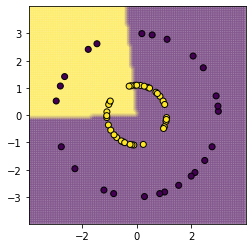

In [46]:
plot_model_prediction(lambda x: model.forward(x), X_test, Y_test)

# 3. Convolutions
## 3.1 Matrix convolution


There is a way to create a **locally connected** layer which will learn local correlations using a smaller amount of parameters.  
This layer is aptly called **Convolutional Layer** and is based on **matrix convolution**

A picture is worth a thousand words which is especially true when learning about convolution:
![Image convolution](./src/conv.png)

In image convolution, a **filter**, also called **kernel**, is applied to the source matrix.  
Each element from the kernel is multiplied by the corresponding element from the source matrix. The results are summed up and written to the target matrix.

In this example, the output matrix has a smaller size than its source\*. This is because the kernel can not overlap the borders. **Zero padding** can be used to retain the original dimension. It is a simple solution which involves adding a border of zeros to the input.

\* It may seem both matrices have the same size (both are shown with the same number of boxes. In the edges of the right matrix, however, no values are stored. The top-left corner of the right image starts where the $-3$ is placed.

The source matrix $X$ is of size $N \times M$ and the kernel $K$ is of size $(2p+1) \times (2q +1 )$.  
We define $X_{ij} = 0$ for $i > N, i < 1$ and $j > M, j < 1$.  
In (other) words: If you try to access a pixel which is out of bounds assume that it is zero.  
This is called **zero padding**.

Therefore, the convolution of a matrix with a kernel is defined as follows:
$$
Y = X \star K \\
Y_{ij} = \sum\limits_{\alpha=0}^{2p} \sum\limits_{\beta=0}^{2q}
K_{\alpha \beta} X_{i + \alpha - p, j+\beta - q}
$$

This operation's name depends on the field:
* In machine learning: **convolution**
* In mathematics: **cross-correlation**

Finally, its time for you to implement matrix convolution.  
You can use the example below this code block to test your implementation.

In [26]:
from scipy.ndimage import correlate

In [26]:
def conv_matrix(matrix, kernel):
    """Perform the convolution of the matrix 
        with the kernel using zero padding
    # Arguments
        matrix: input matrix np.array of size `(N, M)`
        kernel: kernel of the convolution 
            np.array of size `(2p + 1, 2q + 1)`
    # Output
        the result of the convolution
        np.array of size `(N, M)`
    """
    output = np.empty(matrix.shape)
    p = (kernel.shape[0] - 1) // 2
    q = (kernel.shape[1] - 1) // 2
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            y_ij = 0
            for a in range(kernel.shape[0]):
                for b in range(kernel.shape[1]):
                    if (i + a - p < 0) or (i + a - p >= matrix.shape[0]) or (j + b - q < 0) or (j + b - q >= matrix.shape[1]):
                        y_ij = y_ij + kernel[a, b] * 0
                    else:
                        y_ij = y_ij + kernel[a, b] * matrix[i + a - p, j + b - q]
            output[i, j] = y_ij
    return output

### Let's test the function with the following data:

$$
X = \begin{bmatrix}
1 & 2 & 3 \\
2 & 3 & 4 \\
3 & 4 & 5 \\
\end{bmatrix} \quad
K = 
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 2 \\
\end{bmatrix} \quad 
X \star K = 
\begin{bmatrix}
7 & 10 & 3 \\
10 & 14 & 6 \\
3 & 6 & 8 \\
\end{bmatrix}
$$

We recreate the example data in Python to perform a local test run.  
Don't be confused by [np.eye](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.eye.html). It fills our kernel matrix with ones on the diagonal from top-left to bottom-right.

In [27]:
matrix = np.array([
    [1, 2, 3],
    [2, 3, 4],
    [3, 4, 5]
])

kernel = np.array([
    [1, 2, 3, 6],
    [2, 3, 4, 7],
    [3, 4, 5, 8]
])

print(conv_matrix(matrix, kernel))

[[ 87.  58.  38.]
 [144.  93.  58.]
 [ 97.  58.  34.]]


In [28]:
X = np.array([
    [1, 2, 3],
    [2, 3, 4],
    [3, 4, 5]
])

K = np.eye(3)
K[-1, -1] = 2
print(np.zeros(3))
print(K)

[0. 0. 0.]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 2.]]


Run the following code block and compare the result with the example above.

In [29]:
print(conv_matrix(X, K))

[[ 7. 10.  3.]
 [10. 14.  6.]
 [ 3.  6.  8.]]


In [90]:
am.test_student_function(username, conv_matrix, ['matrix', 'kernel'])

Running local tests...
conv_matrix successfully passed local tests
Running remote test...
Test was successful. Congratulations!


## 3.2 Basic kernels

Matrix convolution can be used to process an image (think Instagram): blur, shift, detecting edges, and much more.  
This [article](http://setosa.io/ev/image-kernels/) (**recommended read**) about image kernels should give you a better understanding of convolutions. It happens to be interactive as well.

In convolutional layers, the kernels are learned by training on the dataset. However, there are predefined kernels, for example used on your Instagram photos. Some examples are:

**Sharpen Kernel:** 
$$ 
\begin{equation*}
\begin{bmatrix}
0 & -1 & 0 \\
-1 & 5 & -1 \\
0 & -1 & 0 
\end {bmatrix}
\end{equation*}
$$

**Edge detection filter:**
$$
\begin{equation*}
\begin{bmatrix}
-1 & -1 & -1 \\
-1 & 8 & -1 \\
-1 & -1 & -1 
\end {bmatrix}
\end{equation*}
$$

**Box blur of size 3:**
$$ \frac{1}{9}
\begin{equation*}
\begin{bmatrix}
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1 
\end {bmatrix}
\end{equation*}
$$

Let's play with convolutions by manipulating an image of a dog.

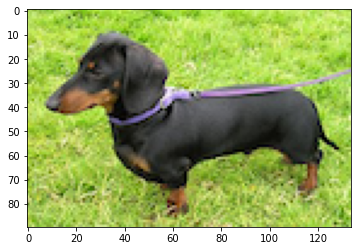

In [30]:
rgb_img = plt.imread('./images/dog.png')
plt.imshow(rgb_img)

Coloured images would require a 3-dimensional tensor to represent RGB (red, green, and blue).  
Therefore, we will convert it to grayscale. This way it can be processed as a matrix.

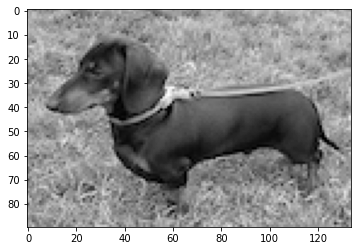

In [31]:
img = rgb_img.mean(axis=2)
plt.imshow(img, cmap='gray')

First of all, let's blur the image with [box blur](https://en.wikipedia.org/wiki/Box_blur). It is just a convolution of a matrix with the kernel of size $N \times N$ of the following form:

$$
\frac{1}{N^2}
\begin{bmatrix}
1 & \dots  & 1\\
\vdots & \ddots & \vdots\\
1 & \dots  & 1\\
\end{bmatrix}
$$

Every element of this filter is *one* and we divide the sum by the total amount of elements in the blur filter. You could understand it as taking the average of an image region.

**Description:**  
Perform the blur of the image.

<u>Arguments:</u>
* `image` - Input matrix - [np.array](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.array.html) of size `(N, M)`
* `box_size` - Size of the blur kernel - `int > 0` the kernel is of size `(box_size, box_size)`

<u>Output:</u>  
The result of the blur [np.array](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.array.html) of size `(N, M)`

In [32]:
def box_blur(image, box_size):
    """Perform the blur of the image
    # Arguments
        image: input matrix - np.array of size `(N, M)`
        box_size: the size of the blur kernel - int > 0  
            the kernel is of size `(box_size, box_size)`
    # Output
        the result of the blur
            np.array of size `(N, M)`
    """   
    kernel = 1/box_size**2 * np.ones((box_size,box_size))
    output = conv_matrix(image, kernel)
    return output

You can test your solution before submitting it. Running the following code block should yield this result:
$$ 
\begin{equation*}
\begin{bmatrix}
1 & 2 & 1 \\
2 & 4 & 2 \\
1 & 2 & 1 
\end {bmatrix}
\end{equation*}
$$

In [33]:
test_image = np.array([
    [9, 0, 9],
    [0, 0, 0],
    [9, 0, 9]
])

print(box_blur(test_image, 3))

[[1. 2. 1.]
 [2. 4. 2.]
 [1. 2. 1.]]


In [106]:
am.test_student_function(username, box_blur, ['image', 'box_size'])

Running local tests...
box_blur successfully passed local tests
Running remote test...
Test was successful. Congratulations!


Let's blur the dog

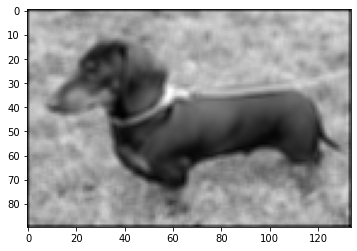

In [34]:
blur_dog = box_blur(img, box_size=3)
plt.imshow(blur_dog, cmap='gray')

Now, we will get the vertical and horizontal gradients. To perform it we calculate the convolution of the image with the following kernels:

$$
K_h = 
\begin{bmatrix}
-1 & 0  & 1\\
\end{bmatrix} \quad
K_v = 
\begin{bmatrix}
1 \\
0 \\
-1\\
\end{bmatrix} \\
X_h = X \star K_h \quad X_v = X \star K_v\\
$$

And then we calculate the amplitude of the gradient:

$$
X_\text{grad} = \sqrt{X_h^2 + X_v^2}
$$

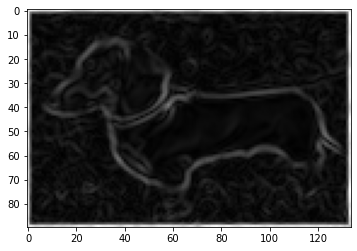

In [35]:
dog_h = conv_matrix(blur_dog, np.array([[-1, 0, 1]]))
dog_v = conv_matrix(blur_dog, np.array([[-1, 0, 1]]).T)
dog_grad = np.sqrt(dog_h ** 2 + dog_v ** 2)
plt.imshow(dog_grad, cmap='gray')

This yields the edges of our blurred dog. It is not the only way to obtain edges though, there are plenty more:
* [Canny edge detection](https://en.wikipedia.org/wiki/Canny_edge_detector)
* [Sobel operator](https://en.wikipedia.org/wiki/Sobel_operator)
* [Prewitt operator](https://en.wikipedia.org/wiki/Prewitt_operator)

When you convolve an image with a kernel you obtain a map of responses. The more correlated the patch of an image is with the kernel, the higher the response. Let's take a closer look:

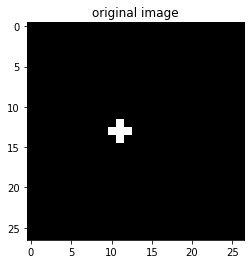

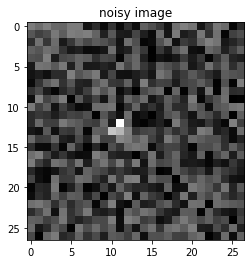

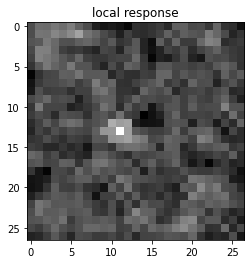

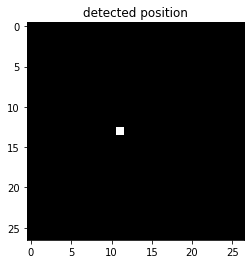

In [36]:
pattern = np.array([
    [0, 1, 0],
    [1, 1, 1],
    [0, 1, 0]
])
# Create the image
image = np.pad(pattern, [(12, 12), (10, 14)], mode='constant', constant_values=0)
plt.imshow(image, cmap='gray')
plt.title('original image')
plt.show()

# Add some noise
image = 0.5 * image + 0.5 * np.random.random(image.shape)
plt.imshow(image, cmap='gray')
plt.title('noisy image')
plt.show()

# Let's find the cross 
response = conv_matrix(image, pattern)
plt.imshow(response, cmap='gray')
plt.title('local response')
plt.show()

plt.imshow(response == response.max(), cmap='gray')
plt.title('detected position')
plt.show()

The brightest pixel highlights where the cross is located. We can find the area where the image is locally close to the kernel. This is especially useful for finding different patterns in images such as: eyes, legs, dogs, cats, etc.

We defined kernels and applied them to images. But we can also **learn** them by minimizing loss and making the processing as effective as possible. In order to do this, we have to define the **Convolutional Layer** in the next chapter.

## 3.3 Convolutional layer

A **Convolutional Layer** works with images. Each image is a 3-dimensional object  $N_{\text{channels}} \times H \times W$.  
Here index *"channels"* refers to the 3 colors (or 1 for black & white images), $H$ to height, and $W$ to width.  
And therefore, the collection of images is 4-dimensional tensor of shape $N_{\text{objects}} \times N_{\text{channels}} \times H \times W$.

For example, 32 RGB images of size $224 \times 224$ are represented as a tensor of shape $32 \times 3 \times 224 \times 224$

A convolutional layer receives an image as its input. Here is how it works:  
The layer has `n_in * n_out` kernels. It is a tensor of size `(n_in, n_out, kernel_h, kernel_w)`  
It takes a 4-dimensional tensor of size `n_objects, n_in, H, W` as its input. 
* `n_objects` is the collection of images. 
* Each of them has `n_in` channels.
* The resolution of the images is `(H, W)`

For each of the images the following operation is performed:  
* In order to get the 1st output channel, all inputs are convolved with their corresponding kernels.  
* Then the results are summed and written to the output channel.  
This is our implementation:
```python
for i in range(n_out):
    out_channel = 0.0
    for j in range(n_in):
        kernel_2d = K[i, j] # Retrieve kernel from the collection of kernels
        input_channel = input_image[j] # Get one channel of the input image
        out_channel += conv_matrix(input_channel, kernel_2d) # Perform convolution
    output_image.append(out_channel) # Append the calculated channel to the output          
```

We implemented the convolutional layer for you. The implementation of `backward` is based on the idea that convolution could be represented as matrix multiplication.

In [37]:
class ConvLayer(Layer):
    """
    Convolutional Layer. The implementation is based on 
        the representation of the convolution as matrix multiplication
    """
    
    def __init__(self, n_in, n_out, filter_size):
        super(ConvLayer, self).__init__()
        self.W = np.random.normal(size=(n_out, n_in, filter_size, filter_size))
        self.b = np.zeros(n_out)
        
    def forward(self, x_input):
        n_obj, n_in, h, w = x_input.shape
        n_out = len(self.W)
        
        self.output = []
        
        for image in x_input:
            output_image = []
            for i in range(n_out):
                out_channel = 0.0
                for j in range(n_in):
                    out_channel += conv_matrix(image[j], self.W[i, j])
                output_image.append(out_channel)
            self.output.append(np.stack(output_image, 0))

        self.output = np.stack(self.output, 0)
        return self.output

    
    def backward(self, x_input, grad_output):

        N, C, H, W = x_input.shape 
        F, C, HH, WW = self.W.shape
        
        pad = int((HH - 1) / 2)

        self.grad_b = np.sum(grad_output, (0, 2, 3)) 

        # pad input array
        x_padded = np.pad(x_input, ((0,0), (0,0), (pad, pad), (pad, pad)), 'constant')
        H_padded, W_padded = x_padded.shape[2], x_padded.shape[3]
        # naive implementation of im2col
        x_cols = None
        for i in range(HH, H_padded + 1):
            for j in range(WW, W_padded+1):
                for n in range(N):
                    field = x_padded[n, :, i-HH:i, j-WW:j].reshape((1,-1))    
                    if x_cols is None:
                        x_cols = field
                    else:
                        x_cols = np.vstack((x_cols, field))
                        
        x_cols = x_cols.T

        d_out = grad_output.transpose(1, 2, 3, 0) 
        dout_cols = d_out.reshape(F, -1) 

        dw_cols = np.dot(dout_cols, x_cols.T) 
        self.grad_W = dw_cols.reshape(F, C, HH, WW) 

        w_cols = self.W.reshape(F, -1) 
        dx_cols = np.dot(w_cols.T, dout_cols) 

        dx_padded = np.zeros((N, C, H_padded, W_padded))
        idx = 0
        for i in range(HH, H_padded + 1):
            for j in range(WW, W_padded + 1):
                for n in range(N):
                    dx_padded[n:n+1, :, i-HH:i, j-WW:j] += dx_cols[:, idx].reshape((1, C, HH, WW))
                    idx += 1
            dx = dx_padded[:, :, pad:-pad, pad:-pad]
        grad_input = dx
        return grad_input
    
    def get_params(self):
        return [self.W, self.b]

    def get_params_gradients(self):
        return [self.grad_W, self.grad_b]

This layer transforms images with 3 channels into images with 8 channels by convolving them with kernels of size `(3, 3)`

In [38]:
conv_layer = ConvLayer(3, 8, filter_size=3)

## 3.4 Pooling layer

The pooling layer **reduces the size of an image**. 

In the following figure $2 \times 2$ pooling is applied on the image which effectively reduces the size by half.  
If you look closely, pooling operations have no effect on the depth of an image.
![pool](./src/pool.png)

There are several types of pooling operations but the most common one is **max pooling**. 

During a max pooling operation, the image is split into **windows** (or **filters**) and then the maximum of each window is used as the output.

![maxpool](./src/maxpool.png)

In [120]:
def maxpool_forward(x_input):
    """Perform max pooling operation with 2x2 window
    # Arguments
        x_input: np.array of size (2 * W, 2 * H)
    # Output
        output: np.array of size (W, H)
    """
    #################
    ### YOUR CODE ###
    ################# 
    W = x_input.shape[0] // 2
    H = x_input.shape[1] // 2

    output = np.empty((W, H))

    maximums = []
    for x in range(0, x_input.shape[0], 2):
        for y in range(0, x_input.shape[1], 2):
            temp = [x_input[x, y], x_input[x, y+1], x_input[x+1, y], x_input[x+1, y+1]]
            maximums.append(max(temp))

    counter = 0
    for i in range(W):
        for j in range(H):
            output[i, j] = maximums[counter]
            counter = counter + 1

    return output

In [121]:
x = np.array([[-5.62283522 , 2.65397255],
 [ 8.12790409 , 0.40023504],
 [-4.86035415 , 1.59388418],
 [ 6.89833031 , 8.04880293],
 [ 6.66358536 , 2.34668278],
 [ 6.34186912 ,-8.63971088],
 [ 5.22584459 ,-1.03840787],
 [-5.36848098 ,-6.20729614],
 [-7.96787592 ,-9.66363678],
 [-2.10888964 ,-4.60126878],
 [-1.26042867 ,-7.16005039],
 [ 6.53684986,  3.53107436]])

maxpool_forward(x)

array([[ 8.12790409],
       [ 8.04880293],
       [ 6.66358536],
       [ 5.22584459],
       [-2.10888964],
       [ 6.53684986]])

Once again, you can use example data to test your solution:  
**Image:**
$$ 
\begin{equation*}
\begin{bmatrix}
1 & 1 & 2 & 4 \\
5 & 6 & 7 & 8 \\
3 & 2 & 1 & 0 \\
1 & 2 & 3 & 4
\end {bmatrix}
\end{equation*}
$$

**Output:**
$$ 
\begin{equation*}
\begin{bmatrix}
6 & 8 \\
3 & 4
\end {bmatrix}
\end{equation*}
$$

In [122]:
test_image = np.array([
    [1, 1, 2, 4],
    [5, 6, 7, 8],
    [3, 2, 1, 0],
    [1, 2, 3, 4]
])

print(maxpool_forward(test_image))

[[6. 8.]
 [3. 4.]]


In [123]:
am.test_student_function(username, maxpool_forward, ['x_input'])

Running local tests...
maxpool_forward successfully passed local tests
Running remote test...
Test was successful. Congratulations!


We already implemented the gradient calculation.  
It is not overly complicated; reading the code should help you to understand the concept.

In [124]:
def maxpool_grad_input(x_input, grad_output):
    """Calculate partial derivative of the loss with respect to the input
    # Arguments
        x_input: np.array of size (2 * W, 2 * H)
        grad_output: partial derivative of the loss 
            with respect to the output 
            np.array of size (W, H)
    # Output
        output: partial derivative of the loss 
            with respect to the input
            np.array of size (2 * W, 2 * H) 
    """
    height, width = x_input.shape
    # create the array of zeros of the required size
    grad_input = np.zeros(x_input.shape)
    
    # let's put 1 if the element with this position 
    # is maximal in the window
    for i in range(0, height, 2):
        for j in range(0, width, 2):
            window = x_input[i:i+2, j:j+2]
            i_max, j_max = np.unravel_index(np.argmax(window), (2, 2))
            grad_input[i + i_max, j + j_max] = 1
            
    # put corresponding gradient instead of 1       
    grad_input = grad_input.ravel()
    grad_input[grad_input == 1] = grad_output.ravel()
    grad_input = grad_input.reshape(x_input.shape)
    return grad_input

Following up is the full implementation of the **MaxPool Layer**.

In [125]:
class MaxPool2x2(Layer):
    
    def forward(self, x_input):
        n_obj, n_ch, h, w = x_input.shape
        self.output = np.zeros((n_obj, n_ch, h // 2, w // 2))
        for i in range(n_obj):
            for j in range(n_ch):
                self.output[i, j] = maxpool_forward(x_input[i, j])
        return self.output 
    
    def backward(self, x_input, grad_output):
        n_obj, n_ch, _, _ = x_input.shape
        grad_input = np.zeros_like(x_input)
        for i in range(n_obj):
            for j in range(n_ch):
                grad_input[i, j] = maxpool_grad_input(x_input[i, j], grad_output[i, j])
        return grad_input

## 3.5 Flatten

Convolutional neural networks are better at image processing than fully connected neural networks (dense networks). We will combine convolutional layers, which deal with 4-dimensional tensors, with dense layers, which work with matrices.  
In order to bridge the gap between convolutional layers and dense layers we will implement the **Flatten Layer**.

The Flatten layer receives a 4-dimensional tensor of size `(n_obj, n_channels, h, w)` as its input and reshapes it into a 2-dimensional tensor (matrix) of size `(n_obj, n_channels * h * w)`.  

The backward pass of this layer is pretty straightforward. Remember that we don't actually change any values; we merely reshape inputs.

**Please implement `flatten_forward` and `flatten_grad_input` functions using [np.reshape](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.reshape.html)**.

In [129]:
def flatten_forward(x_input):
    """Perform the reshaping of the tensor of size `(K, L, M, N)` 
        to the tensor of size `(K, L*M*N)`
    # Arguments
        x_input: np.array of size `(K, L, M, N)`
    # Output
        output: np.array of size `(K, L*M*N)`
    """
    #################
    ### YOUR CODE ###
    #################
    output = np.reshape(x_input, (x_input.shape[0], x_input.shape[1]*x_input.shape[2]*x_input.shape[3]))
    return output

You can use test data and compare the final shape. It should be `(100, 768)` for the following example.  
Please ignore the use of [np.zeros](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.zeros.html) in this case. We are just interested in transforming shapes.  
**Be aware:** This test will fail if you do not return an array like object!

In [130]:
test_input = np.zeros((100, 3, 16, 16))

print(flatten_forward(test_input).shape)

(100, 768)


In [131]:
am.test_student_function(username, flatten_forward, ['x_input'])

Running local tests...
flatten_forward successfully passed local tests
Running remote test...
Test was successful. Congratulations!


In [189]:
def flatten_grad_input(x_input, grad_output):
    """Calculate partial derivative of the loss with respect to the input
    # Arguments
        x_input: np.array of size `(K, L, M, N)`
        grad_output: partial derivative of the loss 
            with respect to the output
            np.array of size `(K, L*M*N)`
    # Output
        output: partial derivative of the loss 
            with respect to the input
            np.array of size `(K, L, M, N)`
    """
    #################
    ### YOUR CODE ###
    #################
    grad_output = np.reshape(grad_output, x_input.shape)
    grad_input = grad_output
    return grad_input

In [190]:
am.test_student_function(username, flatten_grad_input, ['x_input', 'grad_output'])

Running local tests...
flatten_grad_input successfully passed local tests
Running remote test...
Test was successful. Congratulations!


This is the, pretty self-explanatory, implemention of the **Flatten Layer**.

In [191]:
class FlattenLayer(Layer):
    
    def forward(self, x_input):
        self.output = flatten_forward(x_input)
        return self.output
    
    def backward(self, x_input, grad_output):
        output = flatten_grad_input(x_input, grad_output)
        return output

# 4. Image Experiments

This chapter focuses on conducting several experiments. We will train our neural networks with **mini-batches**. Mini-batches are small portions of our dataset, all mini-batches together should form the original dataset again. With our mini-batches in place we will feed these one-by-one to our neural network.

In [192]:
import sys

def iterate_minibatches(x, y, batch_size=16, verbose=True):
    assert len(x) == len(y)
    
    indices = np.arange(len(x))
    np.random.shuffle(indices)
    
    for i, start_idx in enumerate(range(0, len(x) - batch_size + 1, batch_size)):
        if verbose:
            print('\rBatch: {}/{}'.format(i + 1, len(x) // batch_size), end='')
            sys.stdout.flush()
        
        excerpt = indices[start_idx:start_idx + batch_size]
        yield x[excerpt], y[excerpt]

Let's import the data. Please [download](http://yann.lecun.com/exdb/mnist/) it first.

If you get an error with loading the data, chances are you'll need to unpack the downloaded files.

In [206]:
from dataset_utils import load_mnist

In [211]:
train = list(load_mnist(dataset='training', path='.'))
train
train_images = np.array([im[1] for im in train])
train_targets = np.array([im[0] for im in train])
# We will train a 0 vs. 1 classifier
x_train = train_images[train_targets < 2][:1000]
y_train = train_targets[train_targets < 2][:1000]

y_train = y_train 
y_train = y_train.reshape((-1, 1))

You just loaded the MNIST dataset. This dataset consists of gray-scale (so a single channel) images of size `28x28`. These images are represented by the RGB color model. This color model representes a color by 3 integers that range from 0 to 255, or in the case of gray-scale images this is a single integer. This means that each picture in the MNIST dataset is represented by 784 pixels with a value ranging from 0 to 255. This is how a single image looks like:

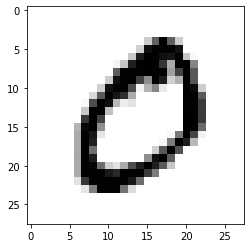

In [212]:
plt.imshow(x_train[0].reshape(28, 28), cmap='gray_r')

To make divergence to an optimum easier, we will normalize the images to have values between 0 and 1. Then, by reshaping, we will add the dimensions for the channel which, for simplicity, was removed by the creators of this dataset. As you can see, this doesn't change anything in how the image looks like.

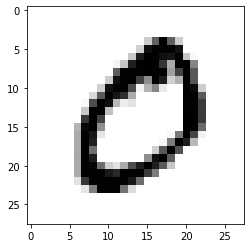

In [213]:
x_train = x_train.astype('float32') / 255.0
x_train = x_train.reshape((-1, 1, 28, 28))
plt.imshow(x_train[0].reshape(28, 28), cmap='gray_r')

Now we will train a simple convolutional neural network:

In [214]:
def get_cnn():
    nn = SequentialNN(
        ConvLayer(1, 2, filter_size=3), # The output is of size [N_obj 2 28 28]
        ReLU(), # The output is of size [N_obj 2 28 28]
        MaxPool2x2(), # The output is of size [N_obj 2 14 14]
        ConvLayer(2, 4, filter_size=3), # The output is of size [N_obj 4 14 14]
        ReLU(), # The output is of size [N_obj 4 14 14]
        MaxPool2x2(), # The output is of size [N_obj 4 7 7]
        FlattenLayer(),  # The output is of size [N_obj 196]
        Dense(4 * 7 * 7, 8),
        ReLU(),
        Dense(8, 1),
        Sigmoid()
    )
    return nn

In [215]:
nn = get_cnn()
loss = NLL()
optimizer = SGD(nn, weight_decay=0.0)

In [216]:
# It will train for about 5 minutes
num_epochs = 5 
batch_size = 32
# We will store the results here
history = {'loss': [], 'accuracy': []}

# `num_epochs` represents the number of iterations
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch + 1, num_epochs))
    
    # We perform iteration a one-by-one iteration of the mini-batches
    for x_batch, y_batch in iterate_minibatches(x_train, y_train, batch_size):
        # Predict the target value
        y_pred = nn.forward(x_batch)
        # Compute the gradient of the loss
        loss_grad = loss.backward(y_pred, y_batch)
        # Perform backwards pass
        nn.backward(x_batch, loss_grad)
        # Update the params
        optimizer.update_params()
        
        # Save loss and accuracy values
        history['loss'].append(loss.forward(y_pred, y_batch))
        prediction_is_correct = (y_pred > 0.5) == (y_batch > 0.5)
        history['accuracy'].append(np.mean(prediction_is_correct))
        
    print()

Epoch 1/5
Batch: 31/31
Epoch 2/5
Batch: 31/31
Epoch 3/5
Batch: 31/31
Epoch 4/5
Batch: 31/31
Epoch 5/5
Batch: 31/31


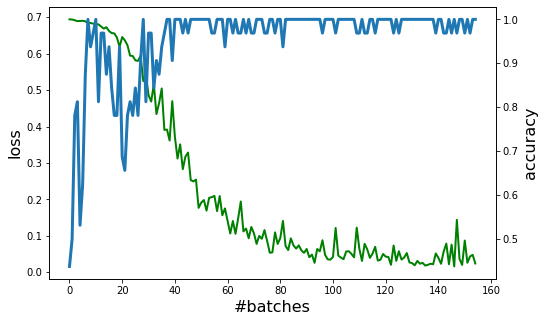

In [217]:
# Let's plot the results to get a better insight
plt.figure(figsize=(8, 5))

ax_1 = plt.subplot()
ax_1.plot(history['loss'], c='g', lw=2, label='train loss')
ax_1.set_ylabel('loss', fontsize=16)
ax_1.set_xlabel('#batches', fontsize=16)

ax_2 = plt.twinx(ax_1)
ax_2.plot(history['accuracy'], lw=3, label='train accuracy')
ax_2.set_ylabel('accuracy', fontsize=16)
plt.show()

**Things you could try:**  
Train the model with a different `batch_size`:
* What would happen with `batch_size=1`?
* What would happen with `batch_size=1000`?
* Does the speed of the computation depend on this parameter? If so, why?

Train the model with a different number of `num_epochs`:
* What would happen with `num_epochs=1`?
* What would happen with `num_epochs=1000`?
* How does it affect computation time, resource strain, and accuracy?

Let's visualize the activations of the intermediate layers:

In [218]:
viz_images = x_batch[:2]
_ = nn.forward(viz_images)

activations = {
    'conv_1': nn.layers[0].output,
    'relu_1': nn.layers[1].output,
    'pool_1': nn.layers[2].output,
    'conv_2': nn.layers[3].output,
    'relu_2': nn.layers[4].output,
    'pool_2': nn.layers[5].output,
}

### Input Images

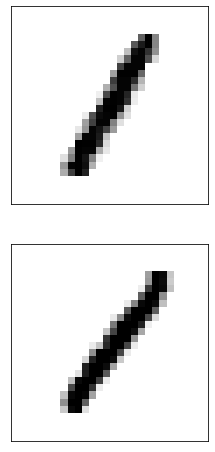

In [219]:
# Input
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 8))

ax1.imshow(viz_images[0, 0], cmap=plt.cm.gray_r)
ax1.set_xticks([])
ax1.set_yticks([])

ax2.imshow(viz_images[1, 0], cmap=plt.cm.gray_r)
ax2.set_xticks([])
ax2.set_yticks([])

plt.show()

### Activations of Conv 1

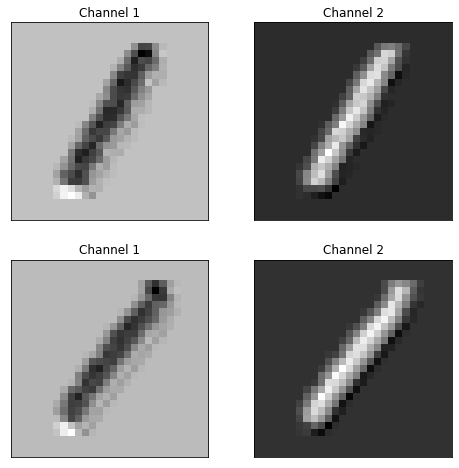

In [220]:
# Conv 1
f, axes = plt.subplots(2, 2, figsize=(8, 8))

for i in range(2):
    for j in range(2):
        ax = axes[i, j]
        ax.imshow(activations['conv_1'][i, j], cmap=plt.cm.gray_r)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('Channel {}'.format(j + 1))

plt.show()

### Activations of ReLU 1

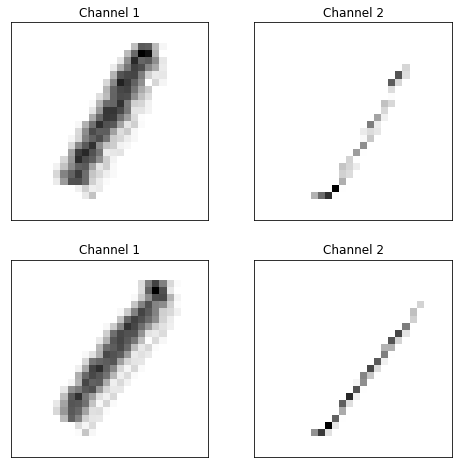

In [221]:
# ReLU 1
f, axes = plt.subplots(2, 2, figsize=(8, 8))

for i in range(2):
    for j in range(2):
        ax = axes[i, j]
        ax.imshow(activations['relu_1'][i, j], cmap=plt.cm.gray_r)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('Channel {}'.format(j + 1))

plt.show()

### Activations of MaxPooling 1

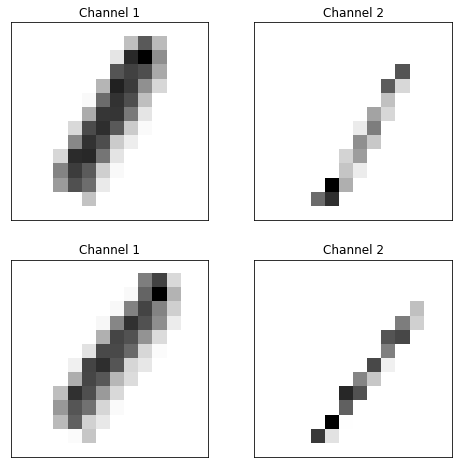

In [222]:
# Max Pooling 1
f, axes = plt.subplots(2, 2, figsize=(8, 8))

for i in range(2):
    for j in range(2):
        ax = axes[i, j]
        ax.imshow(activations['pool_1'][i, j], cmap=plt.cm.gray_r)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('Channel {}'.format(j + 1))

plt.show()

### Activations of Conv 2

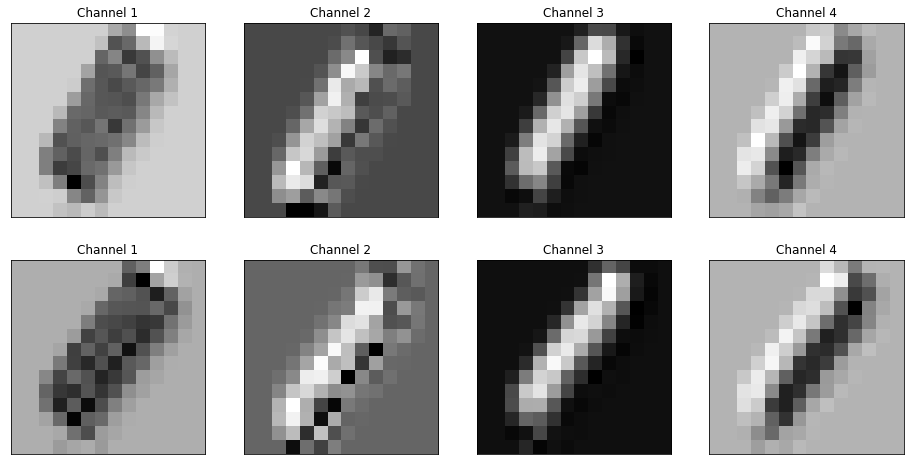

In [223]:
# Conv 2
f, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(2):
    for j in range(4):
        ax = axes[i, j]
        ax.imshow(activations['conv_2'][i, j], cmap=plt.cm.gray_r)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('Channel {}'.format(j + 1))

plt.show()

### Activations of ReLU 2

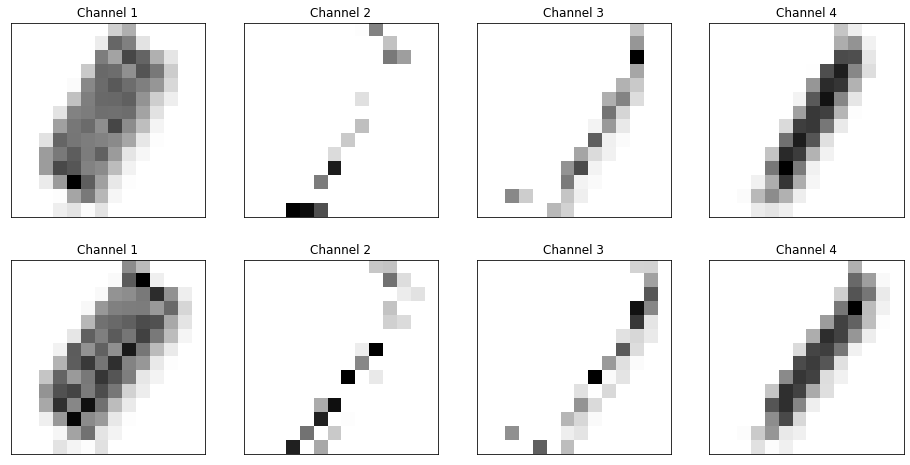

In [224]:
# ReLU 2
f, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(2):
    for j in range(4):
        ax = axes[i, j]
        ax.imshow(activations['relu_2'][i, j], cmap=plt.cm.gray_r)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('Channel {}'.format(j + 1))

plt.show()

### Activations of MaxPooling 2

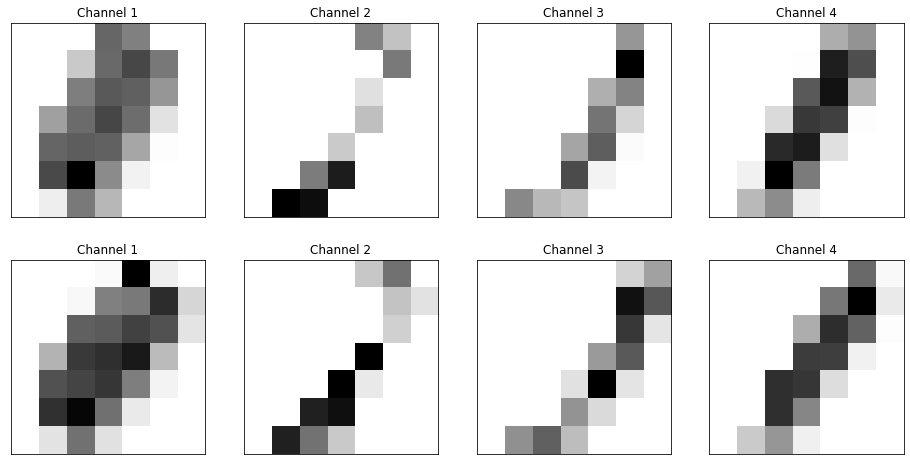

In [225]:
# Max Pooling 2
f, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(2):
    for j in range(4):
        ax = axes[i, j]
        ax.imshow(activations['pool_2'][i, j], cmap=plt.cm.gray_r)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title('Channel {}'.format(j + 1))

plt.show()

As we go deeper and deeper, images become less locally-correlated (the dependance between two neighbours decreases) and more semantically loaded.  
Each convoluted pixel stores more and more useful information about the object.  
In the end, this will be anaylzed using several **Dense Layers**.

**Things you could try:**
* Change the architecture of the neural network
* Vary the number of kernels
* Vary the size of the kernels